In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf

In [3]:
config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)

In [3]:
train_dataset = ShiftedAlignedScore(is_valid= False, min_meas=4, max_meas=6, use_pitch_modification=True, pitch_modification_ratio=0.3)
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4)
train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True, collate_fn=pack_collate)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=pack_collate, drop_last=True)

In [4]:
val_dataset.parts[-1].measures[1]

[Gnote: 46.0, 0.5, 0.0, strong,
 Gnote: 51.0, 0.5, 0.5, weak,
 Gnote: 39.0, 0.0, 1.0, weak,
 Gnote: 51.0, 1.0, 1.0, weak,
 Gnote: 51.0, 1.0, 2.0, weak,
 Gnote: 48.0, 0.5, 3.0, middle,
 Gnote: 51.0, 0.5, 3.5, weak,
 Gnote: 53.0, 0.5, 4.0, weak,
 Gnote: 56.0, 0.5, 4.5, weak,
 Gnote: 39.0, 0.0, 5.0, strong,
 Gnote: 56.0, 1.0, 5.0, strong,
 Gnote: 56.0, 1.0, 6.0, weak,
 Gnote: 53.0, 1.0, 7.0, middle,
 Gnote: 51.0, 1.0, 8.0, weak,
 Gnote: 51.0, 1.0, 9.0, weak]

In [48]:
val_dataset.measure_features[-1][6]

[[7, 39.0, 0.0, 0.0, 'strong', 7],
 [7, 41.0, 1.0, 0.0, 'strong', 7],
 [7, 46.0, 0.5, 1.0, 'weak', 7],
 [7, 41.0, 0.5, 1.5, 'weak', 7],
 [7, 39.0, 1.0, 2.0, 'weak', 7],
 [7, 44.0, 1.0, 3.0, 'middle', 7],
 [7, 44.0, 1.0, 4.0, 'weak', 7],
 [7, 41.0, 1.0, 5.0, 'strong', 7],
 [7, 44.0, 1.0, 6.0, 'weak', 7],
 [7, 46.0, Fraction(1, 3), 7.0, 'middle', 7],
 [7, 44.0, Fraction(1, 3), 7.333, 'weak', 7],
 [7, 41.0, Fraction(1, 3), 7.666, 'weak', 7],
 [7, 39.0, 1.0, 8.0, 'weak', 7],
 [7, 39.0, 1.0, 9.0, 'weak', 7]]

In [ ]:
a, b, c = val_dataset.get_processed_feature

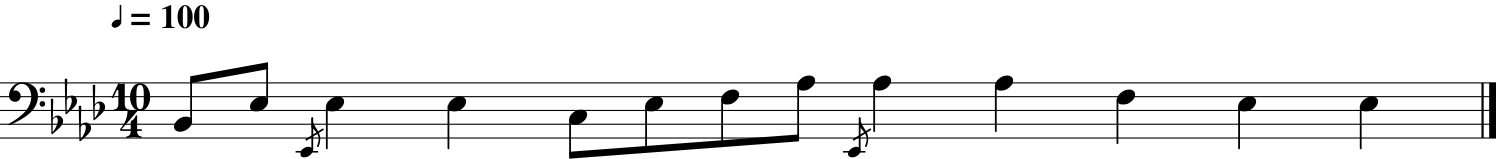

In [40]:
a, b, c = val_dataset.get_processed_feature(7, 7, [1])
decoder(encoding_converter(b[1:])).show()

In [44]:
from metric import convert_note_to_sampling_with_str, make_dynamic_template
dynamic_templates = make_dynamic_template()
converted_inf_result = encoding_converter(b[1:])

convert_note_to_sampling_with_str(converted_inf_result, dynamic_templates)

[[7, 46.0, 1, 'strong'],
 [7, 46.0, 0, 'none'],
 [7, 46.0, 0, 'none'],
 [7, 51.0, 1, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 1, 'weak'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 1, 'weak'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 48.0, 1, 'middle'],
 [7, 48.0, 0, 'none'],
 [7, 48.0, 0, 'none'],
 [7, 51.0, 1, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 51.0, 0, 'none'],
 [7, 53.0, 1, 'weak'],
 [7, 53.0, 0, 'none'],
 [7, 53.0, 0, 'none'],
 [7, 56.0, 1, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 1, 'strong'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 1, 'weak'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 56.0, 0, 'none'],
 [7, 53.0, 1, 'middle'],
 [7

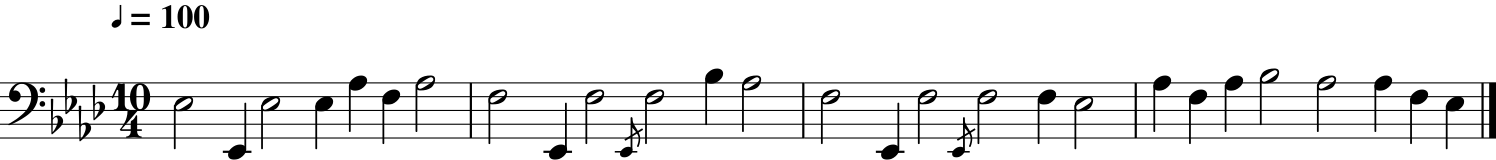

In [25]:
x, y, shifted_y = val_dataset[-1]
encoding_converter = Converter(val_dataset.tokenizer)
decoder = MidiDecoder(val_dataset.tokenizer)
decoder(encoding_converter(y[1:])).show()

In [26]:
encoding_converter(y[1:])

[[7, 51.0, 2.0, 2.0, 'weak', 0],
 [7, 39.0, 1.0, 3.0, 'middle', 0],
 [7, 51.0, 2.0, 5.0, 'strong', 0],
 [7, 51.0, 1.0, 6.0, 'weak', 0],
 [7, 56.0, 1.0, 7.0, 'middle', 0],
 [7, 53.0, 1.0, 8.0, 'weak', 0],
 [7, 56.0, 2.0, 0.0, 'strong', 1],
 [7, 53.0, 2.0, 2.0, 'weak', 1],
 [7, 39.0, 1.0, 3.0, 'middle', 1],
 [7, 53.0, 2.0, 5.0, 'strong', 1],
 [7, 39.0, 0.0, 5.0, 'strong', 1],
 [7, 53.0, 2.0, 7.0, 'middle', 1],
 [7, 58.0, 1.0, 8.0, 'weak', 1],
 [7, 56.0, 2.0, 0.0, 'strong', 2],
 [7, 53.0, 2.0, 2.0, 'weak', 2],
 [7, 39.0, 1.0, 3.0, 'middle', 2],
 [7, 53.0, 2.0, 5.0, 'strong', 2],
 [7, 39.0, 0.0, 5.0, 'strong', 2],
 [7, 53.0, 2.0, 7.0, 'middle', 2],
 [7, 53.0, 1.0, 8.0, 'weak', 2],
 [7, 51.0, 2.0, 0.0, 'strong', 3],
 [7, 56.0, 1.0, 1.0, 'weak', 3],
 [7, 53.0, 1.0, 2.0, 'weak', 3],
 [7, 56.0, 1.0, 3.0, 'middle', 3],
 [7, 58.0, 2.0, 5.0, 'strong', 3],
 [7, 56.0, 2.0, 7.0, 'middle', 3],
 [7, 56.0, 1.0, 8.0, 'weak', 3],
 [7, 53.0, 1.0, 9.0, 'weak', 3],
 [7, 51.0, 1.0, 0.0, 'strong', 8]]

MusicXMLExportException: In part (None), measure (2): Cannot convert durations without types to MusicXML.

In [9]:
val_dataset[0]

(tensor([[ 0,  1,  1,  1,  1,  1],
         [ 0,  8, 15,  3,  3,  3],
         [ 0,  6, 13, 19,  3,  3],
         [ 0,  5,  3,  3,  3,  4],
         [ 0,  5,  3,  3,  3,  5],
         [ 0, 13,  3,  3,  3,  6],
         [ 0,  2,  2,  2,  2,  2]]),
 tensor([[ 1,  1,  1,  3,  3,  3],
         [ 1,  5,  4,  3,  3,  3],
         [ 1,  6, 11,  7,  5,  3],
         [ 1,  8,  8, 11,  4,  3],
         [ 1,  9, 11, 19,  3,  3],
         [ 1,  5,  4, 19,  3,  3],
         [ 1,  8, 11, 25,  5,  3],
         [ 1,  6,  8,  3,  3,  4],
         [ 1,  5,  4,  3,  3,  4],
         [ 1,  5, 15, 19,  3,  4],
         [ 1,  5, 13,  3,  3,  5],
         [ 1,  5,  4,  3,  3,  5],
         [ 1,  5, 15, 19,  3,  5],
         [ 1,  5, 13,  3,  3,  6],
         [ 1,  5,  4,  3,  3,  6],
         [ 1, 13, 15, 19,  3,  6],
         [ 1, 13, 13,  3,  3,  5]]),
 tensor([[ 1,  5,  4,  3,  3,  3],
         [ 1,  6, 11,  7,  5,  3],
         [ 1,  8,  8, 11,  4,  3],
         [ 1,  9, 11, 19,  3,  3],
         [ 1,  5

In [30]:
train_dataset[0]

(tensor([[ 1,  1,  1,  1,  1,  1],
         [ 1, 10, 13,  3,  3,  3],
         [ 1, 10, 11, 19,  3,  3],
         [ 1, 10, 13,  3,  3,  4],
         [ 1, 10,  6, 19,  3,  4],
         [ 1, 11,  6, 22,  5,  4],
         [ 1, 10,  6, 25,  5,  4],
         [ 1,  8, 11,  3,  3,  5],
         [ 1,  7,  9, 11,  4,  5],
         [ 1,  8,  6, 19,  3,  5],
         [ 1, 10,  6, 22,  5,  5],
         [ 1,  8,  6, 25,  5,  5],
         [ 1,  7,  9,  3,  3,  6],
         [ 1,  6,  6,  7,  5,  6],
         [ 1,  7,  9, 11,  4,  6],
         [ 1,  8,  6, 19,  3,  6],
         [ 1,  7,  6, 22,  5,  6],
         [ 1,  8,  6, 25,  5,  6],
         [ 1,  2,  2,  2,  2,  2]]),
 tensor([[ 3,  1,  1,  3,  3,  3],
         [ 3, 12,  6,  5,  5,  3],
         [ 3, 12,  9, 11,  4,  3],
         [ 3, 15, 11, 22,  3,  3],
         [ 3,  9,  9, 29,  4,  3],
         [ 3, 16,  6, 32,  5,  3],
         [ 3, 12,  6,  3,  3,  4],
         [ 3, 10,  9,  7,  5,  4],
         [ 3,  8,  6, 11,  4,  4],
         [ 3, 10, 

In [4]:
batch = next(iter(valid_loader))

In [31]:
device = 'cuda'
model = QkvAttnSeq2seq(train_dataset.tokenizer, config.model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nll_loss
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader, device, save_log=False)

In [32]:
trainer.train_by_num_epoch(160)

  0%|          | 0/160 [00:00<?, ?it/s]

Best Model Saved! Accuracy: 0.27210765028711
Best Model Saved! Accuracy: 0.3237123905654244
Best Model Saved! Accuracy: 0.3517254773173204
Best Model Saved! Accuracy: 0.364043287737884
Best Model Saved! Accuracy: 0.38078974563336204
Best Model Saved! Accuracy: 0.42863297329603206
Best Model Saved! Accuracy: 0.44407366849481367
Best Model Saved! Accuracy: 0.45589003675709794
Best Model Saved! Accuracy: 0.4611038740454967
Best Model Saved! Accuracy: 0.4847369064401809
Best Model Saved! Accuracy: 0.5040129888245669
Best Model Saved! Accuracy: 0.5154437205011068
Best Model Saved! Accuracy: 0.5303314868924839
Best Model Saved! Accuracy: 0.5438915738152313
Best Model Saved! Accuracy: 0.5631381896604198
Best Model Saved! Accuracy: 0.582302542913389
Best Model Saved! Accuracy: 0.5947231453358756
Best Model Saved! Accuracy: 0.5996162038274114
Best Model Saved! Accuracy: 0.6150918013421277
Best Model Saved! Accuracy: 0.6392289032351236
Best Model Saved! Accuracy: 0.6436800912190596
Best Model Sa

[tensor([[[5.0537e-04, 6.3610e-04, 4.9355e-05,  ..., 3.3314e-02,
           3.3314e-02, 3.3314e-02],
          [9.7436e-01, 8.5222e-01, 8.4629e-04,  ..., 4.6411e-02,
           4.6411e-02, 4.6411e-02],
          [1.0690e-02, 1.0735e-01, 1.0884e-02,  ..., 5.7896e-02,
           5.7896e-02, 5.7896e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[2.5076e-02, 5.3752e-03, 9.1033e-04,  ..., 3.1645e-02,
           3.1645e-02, 3.1645e-02],
          [7.7976e-01, 9.5330e-01, 4.1342e-04,  ..., 4.7138e-02,
           4.7138e-02, 4.7138e-02],
          [1.9420e-01, 8.6862e-03, 9.9857e-01,  ..., 2.7795e-02,
           2.7795e-02, 2.7795e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

In [35]:
print(sample[0][0])
input_part_idx = sample[0][0]
src, output, attn_map = model.shifted_inference(sample, input_part_idx+1)

tensor(5)
tensor([[ 5,  1,  1,  1,  1,  1],
        [ 5, 10,  9,  3,  3,  3],
        [ 5,  8,  6,  7,  5,  3],
        [ 5,  7, 11, 11,  4,  3],
        [ 5,  7,  9, 22,  3,  3],
        [ 5,  8,  6, 29,  4,  3],
        [ 5, 11,  6, 32,  5,  3],
        [ 5, 10,  9,  3,  3,  4],
        [ 5,  4,  6,  7,  5,  4],
        [ 5, 10, 11, 11,  4,  4],
        [ 5, 10,  6, 22,  3,  4],
        [ 5, 13,  6, 25,  5,  4],
        [ 5, 11,  6, 29,  4,  4],
        [ 5, 13,  6, 32,  5,  4],
        [ 5,  2,  2,  2,  2,  2]])


In [10]:
state = torch.load('best_model.pt')
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
len(attn_map)

In [493]:
import matplotlib.pyplot as plt

plt.imshow(attn_map[0][5].detach().cpu().numpy())

NameError: name 'attn_map' is not defined

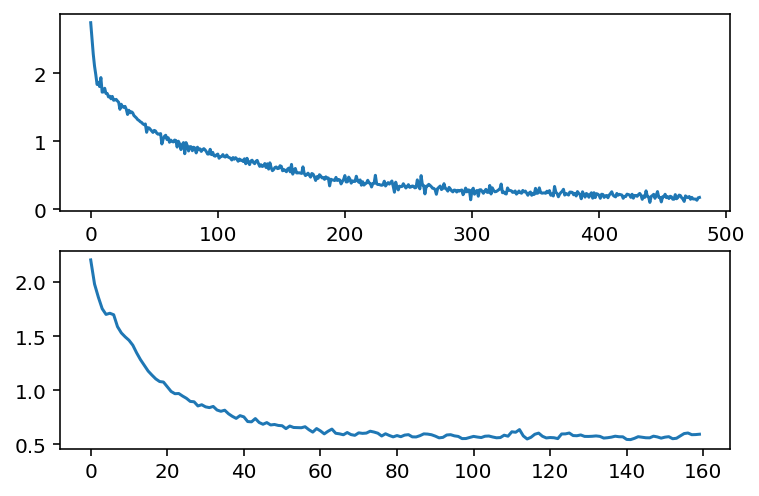

In [26]:
from matplotlib import pyplot as plt

plt.subplot(2,1,1)
plt.plot(trainer.training_loss)
plt.subplot(2,1,2)
plt.plot(trainer.validation_loss)

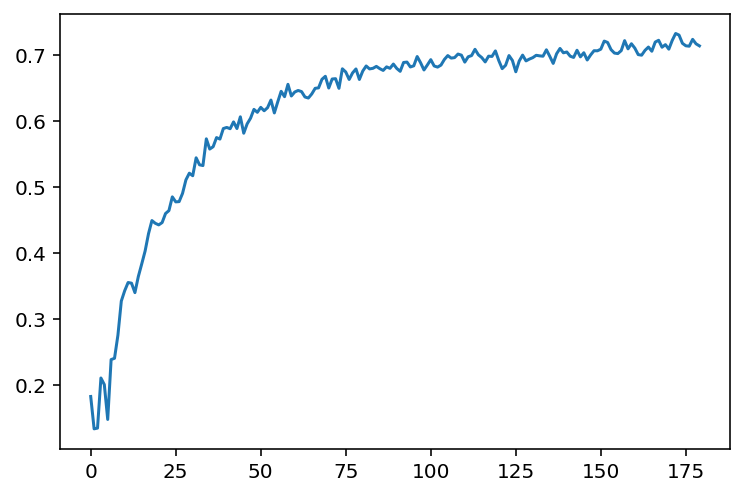

In [12]:
plt.plot(trainer.validation_acc)

## Inference

In [5]:
selected_idx_list = [i for i in range(63)][0::7]
selected_idx_list

[0, 7, 14, 21, 28, 35, 42, 49, 56]

In [25]:
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate)
model.to('cpu')
val_part_idx_info = defaultdict(list)
for i, val in enumerate(val_dataset):
    val_part_idx_info[int(val[0][0][0])].append(i)
val_part_idx_info

defaultdict(list,
            {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
             1: [16,
              17,
              18,
              19,
              20,
              21,
              22,
              23,
              24,
              25,
              26,
              27,
              28,
              29,
              30,
              31],
             2: [32, 33, 34, 35, 36, 37, 38, 39],
             3: [40, 41, 42, 43, 44, 45, 46, 47],
             5: [48,
              49,
              50,
              51,
              52,
              53,
              54,
              55,
              56,
              57,
              58,
              59,
              60,
              61,
              62,
              63],
             6: [64, 65, 66, 67, 68, 69, 70, 71]})

In [7]:
len(valid_loader.dataset)

63

In [37]:
import matplotlib.pyplot as plt
valid_dataset_idx = 0
output_part_idx = 1

sample = valid_loader.dataset[valid_dataset_idx][0]
# src, output, attention_map = model.inference(sample, output_part_idx)
src, output, attention_map = model.shifted_inference(sample, output_part_idx)

decoder = MidiDecoder(valid_loader)
src_midi = decoder(src)
output_midi = decoder(output)

merged_midi = stream.Stream()
for element in src_midi:
    merged_midi.append(element)
for element in output_midi:
    merged_midi.append(element)

merged_midi.write('musicxml.png', "source_and_output.png")

# output_midi.show()


tensor([[ 5,  1,  1,  1,  1,  1],
        [ 5, 10,  9,  3,  3,  3],
        [ 5,  8,  6,  7,  5,  3],
        [ 5,  7, 11, 11,  4,  3],
        [ 5,  7,  9, 22,  3,  3],
        [ 5,  8,  6, 29,  4,  3],
        [ 5, 11,  6, 32,  5,  3],
        [ 5, 10,  9,  3,  3,  4],
        [ 5,  4,  6,  7,  5,  4],
        [ 5, 10, 11, 11,  4,  4],
        [ 5, 10,  6, 22,  3,  4],
        [ 5, 13,  6, 25,  5,  4],
        [ 5, 11,  6, 29,  4,  4],
        [ 5, 13,  6, 32,  5,  4],
        [ 5,  2,  2,  2,  2,  2]])


PosixPath('/home/danbi/userdata/DANBI/gugakwon/Yeominrak/source_and_output-1.png')

In [18]:

sample

tensor([[ 0,  1,  1,  1,  1,  1],
        [ 0,  6, 10,  3,  3,  3],
        [ 0,  5,  7,  9,  3,  3],
        [ 0,  4, 12,  3,  3,  4],
        [ 0,  2,  2,  2,  2,  2]])

In [56]:

output = [val_dataset.tokenizer(note) for note in output]



KeyError: 6

In [32]:
output

[[1, 6, 9, 7, 5],
 [1, 4, 6, 11, 4],
 [1, 6, 9, 19, 3],
 [1, 9, 6, 22, 5],
 [1, 6, 6, 25, 5],
 [1, 5, 6, 3, 3],
 [1, 6, 13, 19, 3],
 [1, 10, 11, 3, 3],
 [1, 11, 13, 19, 3],
 [1, 11, 11, 3, 3],
 [1, 13, 9, 7, 5],
 [1, 13, 6, 11, 4],
 [1, 14, 9, 19, 3],
 [1, 14, 9, 25, 5],
 [1, 5, 6, 3, 3],
 [1, 11, 13, 19, 3],
 [1, 13, 11, 3, 3],
 [1, 11, 9, 7, 5],
 [1, 13, 6, 11, 4],
 [1, 14, 9, 19, 3],
 [1, 13, 6, 22, 5],
 [1, 14, 6, 25, 5],
 [1, 13, 6, 3, 3]]

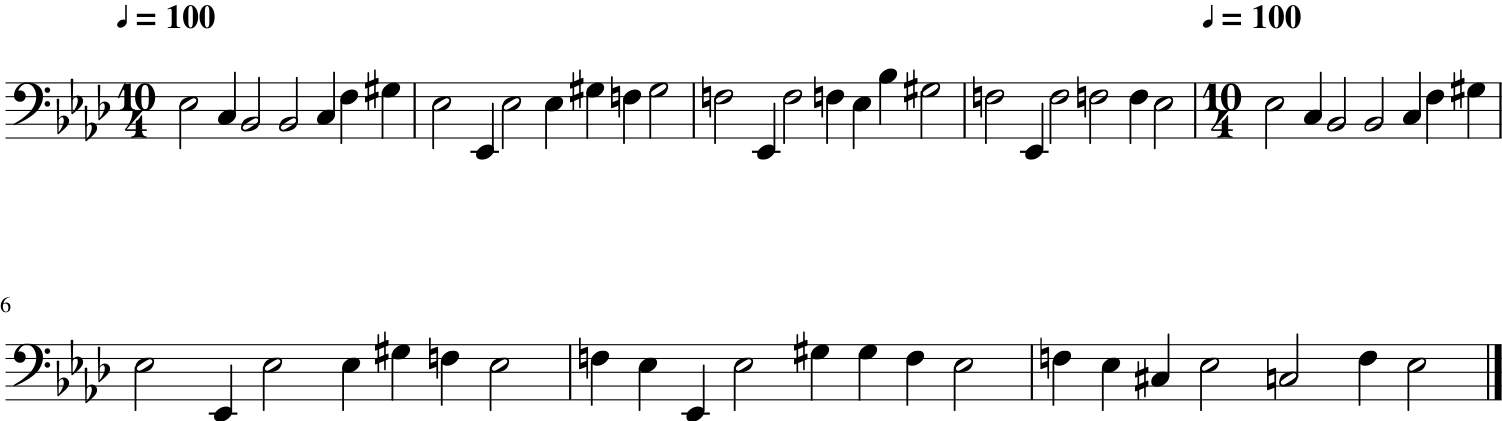

In [19]:
from metric import get_correspondence_with_inference, make_dynamic_template, get_similarity_with_inference

model.to('cpu')
# for idx in range(self.valid_loader.batch_size):
selected_idx_list = [i for i in range(len(valid_loader.dataset))][0::7]
measure_match = []
similarity = []
dynamic_corr = []
dynamic_templates = make_dynamic_template(offset_list=[4.0, 8.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
for idx in selected_idx_list:
  sample = valid_loader.dataset[idx][0]
  input_part_idx = sample[0][0]
  src, output, attn_map = model.shifted_inference(sample, input_part_idx+1)
  is_match = sum([note[2] for note in src]) == sum([note[2] for note in output])
  measure_match += [is_match]
  if is_match:
    similarity += [get_similarity_with_inference(src, output, dynamic_templates)]
    dynamic_corr += [get_correspondence_with_inference(src, output, dynamic_templates)]
  
  src_midi, output_midi = trainer.midi_decoder(src), trainer.midi_decoder(output)

  merged_midi = stream.Stream()
  for element in src_midi:
    merged_midi.append(element)
  for element in output_midi:
    merged_midi.append(element)

merged_midi.show()

In [20]:
model.cpu()
valid_dataset_idx = 0
output_part_idx = 1
decoder = MidiDecoder(valid_loader)
merged_midi = stream.Stream()
sample = valid_loader.dataset[valid_dataset_idx][0]

for i in range(7):    
  src, output, attention_map = model.shifted_inference(sample, output_part_idx)
  if i == 0:
    src_midi = decoder(src)
    for element in src_midi:
      merged_midi.append(element)
  print(i)
  output_midi = decoder(output)
  for element in output_midi:
    merged_midi.append(element)
  sample = [val_dataset.tokenizer(note) for note in output]
  sample = torch.Tensor(sample).long()
  print(sample)
  output_part_idx += 1

merged_midi.write('musicxml.png', "source_and_output.png")


# src, output, attention_map = model.inference(sample, output_part_idx)







0
tensor([[ 1,  6,  9,  7,  5,  3],
        [ 1,  5,  9, 15,  5,  3],
        [ 1,  5,  6, 19,  3,  3],
        [ 1,  6,  9, 25,  5,  3],
        [ 1,  5,  6,  3,  3,  4],
        [ 1,  4, 11, 11,  4,  4],
        [ 1,  4,  9, 19,  3,  4],
        [ 1,  5, 11,  3,  3,  5],
        [ 1, 11,  9,  7,  5,  5],
        [ 1, 10,  6, 11,  4,  5],
        [ 1,  9,  9, 19,  3,  5],
        [ 1,  5,  9, 25,  5,  5],
        [ 1,  6,  6,  3,  3,  6]])


KeyError: 10

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)


## Attention map

In [ ]:
# src = attn_map[0][0].shape[0]
# output = attn_map[0][0].shape[1]
plt.figure(figsize=(15, 15))
x_axis_label = ['start']+[i for i, x in enumerate(src)]+['end']
y_axis_label = [i for i, x in enumerate(output)]


plt.imshow(attention_map.detach())
plt.yticks(range(len(x_axis_label)), x_axis_label, fontsize=15,rotation = 45)
plt.xticks(range(len(y_axis_label)), y_axis_label, fontsize=15)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(attn_map[3][3].cpu().detach().numpy())

In [ ]:
plt.figure(figsize = (30, 30))
wei = abs(model.decoder.proj.weight.detach())
plt.imshow(wei)

# Other works

In [ ]:
score_set = train_dataset = AlignedScore(slice_measure_num = 4, sample_len = 1000, is_valid = False, use_pitch_modification=False)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(part5.make_pitch_contour())

In [ ]:
part, i = score_set.score.parts[5], 5
part5 = Part(part, i)
part5.measure_duration
print(part5.measures)

# # while True:
#   entire_beat = part5.measure_duration
#   for measure in part5.measures:
#     part = score_set.score.parts[5]
# # part5 = Part(part, i) 
#     current_beat = sum(note.duration for note in measure)
#     # print(current_beat, entire_beat)
#     if current_beat < entire_beat:
#       # print(current_beat, entire_beat)
#       # print(measure)
#       # print(measure[-1].offset, measure[-1].duration)
#       new_note = m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat)
#       part.insert(measure[-1].offset+measure[-1].duration, new_note)
#       # measure.append(Gnote(m21_note.Note(pitch=30, quarterLength=entire_beat - current_beat, offset=measure[-1].offset+measure[-1].duration), 5))
#       print('added!')
#       break
  
#   # sum_list = [sum(note.duration for note in measure) for measure in part5.measures]
#   # if sum(sum_list) == len(part5.measures) * entire_beat:
#   #   print("done?")
#   #   break
  
# # for i, measure in enumerate(part5.measures):
# #   current_beat = sum(note.duration for note in measure)
# #   entire_beat = part5.measure_duration
# #   if current_beat < entire_beat:
# #     print(measure)

In [ ]:
whole_score = converter.parse(file_list[0])

by_measure_parse_dic = defaultdict()
for part_idx in range(len(whole_score.parts)):
  part_dic = defaultdict(list)
  for note in whole_score.parts[part_idx].flat.notes:
    if not note.duration.isGrace:
      part_dic[note.measureNumber].append(note)
  by_measure_parse_dic[part_idx] = part_dic


In [ ]:
part.measure

In [ ]:
print(score_set.parts[5].make_pitch_contour())

In [ ]:
contours = [part.make_pitch_contour() for part in score_set.parts]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

measure_sample = 120
measure_by_contour = [contours[-1][i * measure_sample : (i + 1) * measure_sample] for i in range(160)]

self_similarity_matrix = np.zeros((160, 160))

for i, measure1 in enumerate(measure_by_contour):
    for j, measure2 in enumerate(measure_by_contour):
        similarity = np.sum(measure1 == measure2) / measure_sample  # Calculate similarity
        self_similarity_matrix[i, j] = similarity

plt.figure(figsize=(12, 12))
plt.imshow(self_similarity_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Self-Similarity Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

measure_start = 0
measure_end = 30

sampling_rate = 12

start_idx = measure_start * 10 * sampling_rate
end_idx = measure_end * 10 * sampling_rate

plt.figure(figsize = (50, 10))
for contour in contours:
  plt.plot(contour[start_idx:end_idx])


In [ ]:
len(score_set.parts[0].measures)

In [ ]:
12/5

In [ ]:
score_set.parts[-1].measure_duration

In [ ]:
min([note.duration for note in score_set.parts[-3].tie_cleaned_notes])

In [ ]:
for i, part in enumerate(train_dataset.parts):
  for j, measure in enumerate(part.measures):
    for note in measure:
      if note.pitch == 49:
        print(i, j, note)
